# Machine Learning appliqué à la géolocalisation de balises IOT

**Antonin Durieux  
Parfait Fangue Megaptche  
Guillaume Lehericy  
Ialifinaritra Rakotoniaina**

Le but de cet exercice va être de déterminer la géolocalisation d'objets émettant des signaux sur le réseau Sigfox.  
Pour cela on dispose de :
- Un jeu de messages d'entrainement, qui pour chaque exemple contient:
    - l'id du message, 
    - l'id de la base station (station de réception), 
    - l'id du device, 
    - une variable nseq (dont la signification nous est inconnue), 
    - le Rssi (puissance du signal reçu), 
    - l'heure de réception,
    - les coordonnées de la base de réception.
- Un jeu de test comprenant les variables similaires au jeu d'entrainement;
- Les positions réelles des objets emettant des messages dans le jeu d'entrainement.

Il s'agit donc d'un problème de régression sur des coordonnées. Une matrice de variables devra être exploitée en entrée d'un algorithme de machine learning pour déterminer au mieux les positions des objets emettant les messages reçus.

#### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneGroupOut
import seaborn as sns

## 1. Import des données 

In [2]:
# Import des 3 fichiers CSV de données
df_mess_train = pd.read_csv('data/mess_train_list.csv')
df_mess_test = pd.read_csv('data/mess_test_list.csv')
pos_train = pd.read_csv('data/pos_train_list.csv')

In [3]:
# Messages d'entrainement
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [4]:
df_mess_train.shape

(39250, 8)

In [5]:
# Positions correspondants aux messages d'entrainement
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [6]:
pos_train.shape

(39250, 2)

In [7]:
# Messages de test
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [8]:
df_mess_test.shape

(29286, 8)

Le jeu d'entrainement comporte 39250 lignes, chacune correspondant à la réception d'un message par une base station. 
Les positions du DataFrame pos_train correspondent à la localisation des objets ayant émis chacun des messages du jeu d'entrainement.  
Le jeu de test comporte 29286 lignes, correspondantes à la réception de messages émis par des objets dont on ne connait pas la localisation.

In [9]:
# Nombre de base stations totales dans les jeu train et test
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) 
print("nombre de base stations total : {}".format(len(listOfBs)))

nombre de base stations total : 259


In [10]:
# Nombre de messages différents dans le jeu train
listOfMessId_train = np.unique(df_mess_train['messid'])
print("nombre de messages différents dans le jeu d'entrainement : {}".format(len(listOfMessId_train)))

nombre de messages différents dans le jeu d'entrainement : 6068


In [11]:
# Nombre d'objets différents dans le jeu train
listOfMessId_train = np.unique(df_mess_train['did'])
print("nombre d'objets différents dans le jeu d'entrainement : {}".format(len(listOfMessId_train)))

nombre d'objets différents dans le jeu d'entrainement : 113


In [12]:
# Nombre de messages différents dans le jeu test
listOfMessId_test = np.unique(df_mess_test['messid'])
print("nombre de messages différents dans le jeu de test : {}".format(len(listOfMessId_test)))

nombre de messages différents dans le jeu de test : 5294


In [13]:
# Nombre d'objets différents dans le jeu train
listOfMessId_test = np.unique(df_mess_test['did'])
print("nombre d'objets différents dans le jeu de test : {}".format(len(listOfMessId_test)))

nombre d'objets différents dans le jeu de test : 56


## 2. Positionnement

Nous allons étudier comment se répartissent les positions des base stations et des objets du jeu d'entrainement.

In [14]:
# Pour faire fonctionner le module Basemap
import os
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

/home/antonin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/home/antonin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/antonin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':


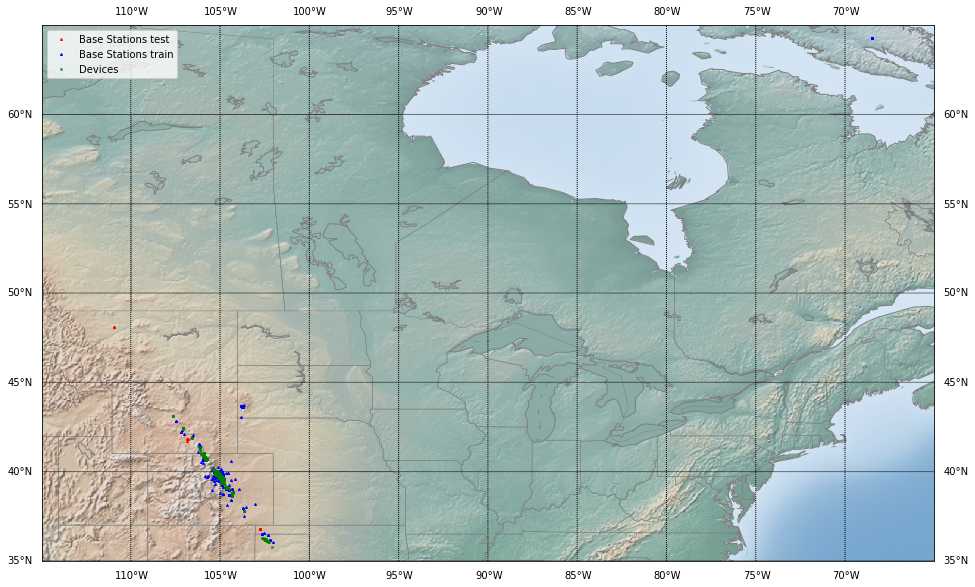

In [16]:
# Background
fig = plt.figure(figsize=(16, 16))
m = Basemap(projection='cyl', resolution='l',
            llcrnrlon=-115, llcrnrlat= 35, 
            urcrnrlon=-65, urcrnrlat=65)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawparallels(np.arange(35,65,5), labels=[1,1,1,1])
m.drawmeridians(np.arange(-110,-65,5), labels=[1,1,1,1])

# Base stations test
bs_lat_test, bs_lng_test = m(df_mess_test.bs_lat.values, df_mess_test.bs_lng.values)
plt.plot(bs_lng_test, bs_lat_test,'^r', markersize=2, label='Base Stations test')

# Base stations train
bs_lat_train, bs_lng_train = m(df_mess_train.bs_lat.values, df_mess_train.bs_lng.values)
plt.plot(bs_lng_train, bs_lat_train,'^b', markersize=2, label='Base Stations train')

# Positions des objets du jeu d'entrainement
device_lat, device_lng = m(pos_train.lat.values, pos_train.lng.values)
plt.plot(device_lng, device_lat,'xg', markersize=2, label='Devices')

plt.legend()
plt.show()

On remarque que la plupart des objets et bases stations sont situés dans un carré 110°W-100°W / 35°N-45°N. Il y a cependant des outliers parmis l'ensemble des bases. En particulier, certaines stations sont positionnées dans le Nunavut, il est impossible qu'elles aient reçus des message à cette distance, leur position est donc erronée. Les stations situées aux alentours de 106°W / 44°N sont également suspectes.

In [17]:
# Stations situées dans le Nunavut (train)
print("Base stations positionnées dans le Nunavut - jeu d'entrainement : ")
print(np.unique(df_mess_train[df_mess_train.bs_lng > -70]['bsid']))

Base stations positionnées dans le Nunavut - jeu d'entrainement : 
[ 1092  1594  1661  1743  1772  1796  1854  2293  2707  2943  4123  4129
  4156  4959  4987  4993  7248  8355  8449  8451  8560  9784 10151 10162
 10999 11007 11951]


In [18]:
# Stations situées dans le Nunavut (test)
print("Base stations positionnées dans le Nunavut - jeu de test : ")
print(np.unique(df_mess_test[df_mess_test.bs_lng > -70]['bsid']))

Base stations positionnées dans le Nunavut - jeu de test : 
[ 1092  1594  1661  1743  1772  1796  1854  2707  2943  4129  4156  4987
  4993  7248  8355  8449  8451  8560  9941  9949 10151 10162 11007]


Le jeu d'entrainement compte 27 stations positionnées dans le Nunavut, le jeu test en compte 23, dont certaines ne figurent pas dans le jeu d'entrainement.

On voit donc que certaines stations peuvent être mal positionnées, aussi bien dans le jeu d'entrainement que dans le jeu de test.  
Si on base nos calculs uniquement sur le RSSI par la suite en admettant que ceux-cis sont corrects, cela ne sera pas gênant.  
En revanche si nous étions amenés à calculer des distances entre devices et base stations il y aurait des corrections à effectuer.

## 3. Construction des matrices de features et ground truth

Plusieurs essais ont été effectués pour remplir la matrice de features : évaluations de distances en fonction du rssi, rssi normalisé sur différents ranges, rssi brut... Au final, les meilleurs résultats ont été obtenus en affectant la valeur de rssi brut reçu par chaque antenne pour chaque message. Cette valeur de rssi agira comme un poids dans l'algorithme d'apprentissage.

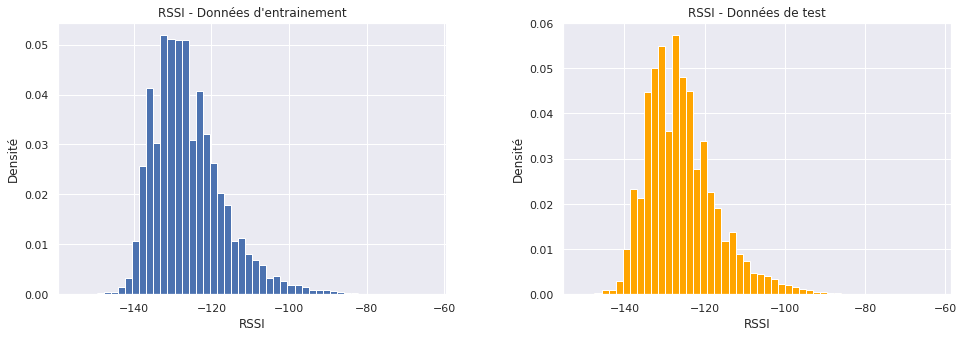

In [36]:
# Histogrammes des rssi
sns.set()

plt.figure(figsize=(16, 5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

df_mess_train.hist(column='rssi', bins=50, ax=ax1, density=1)
ax1.set_title("RSSI - Données d'entrainement")
ax1.set_xlabel("RSSI")
ax1.set_ylabel("Densité")

df_mess_test.hist(column='rssi', bins=50, ax=ax2, density=1, color='orange')
ax2.set_title("RSSI - Données de test")
ax2.set_xlabel("RSSI")
ax2.set_ylabel("Densité")

plt.show()

On voit que les valeurs de RSSI sont distribuées de manière relativement similaire entre les jeux d'entrainement et de test. Ces valeurs ne semblent pas présenter d'outliers particuliers.

In [19]:
# Fonction de construction de la matrice de features
def feat_mat_const(df_mess_train, listOfBs):
    
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    df_feat['did'] = np.nan
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:      
        # Remplissage de la matrice avec les RSSI
        for bsid in df_mess_bs_group.get_group(key)['bsid']:
            rssi = df_mess_train.loc[(df_mess_train.messid==key) & (df_mess_train.bsid==bsid)]['rssi'].values
            df_feat.loc[idx,bsid] = rssi
        # Renseignement du device id
        if df_mess_bs_group.get_group(key).did.nunique() != 1:
            print("Erreur: device id non unique pour le message {}".format(key))
        else:
            device_id = df_mess_bs_group.get_group(key).did.values[0]
        df_feat.loc[idx,'did'] = device_id
        
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

La ground truth est la position des devices lors de l'émission de chacun des messages dans le jeu d'entrainement :

In [20]:
# Fonction de renvoi de la ground truth
def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [21]:
# Calcul de la matrice de feature
df_feat, id_list_train = feat_mat_const(df_mess_train, listOfBs)

In [22]:
# Ground truth
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth = np.stack([ground_truth_lat, ground_truth_lng], axis=1)

In [23]:
df_feat.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9941,9949,10134,10148,10151,10162,10999,11007,11951,did
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473335.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473335.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473953.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476512.0
4,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476286.0


In [24]:
df_feat.shape

(6068, 260)

In [25]:
ground_truth

array([[  39.60668952, -104.95848993],
       [  39.63774123, -104.95855416],
       [  39.73041743, -104.96894015],
       ...,
       [  39.77887196, -105.01928515],
       [  39.77326419, -105.01405242],
       [  39.90818599, -105.16829706]])

In [26]:
ground_truth.shape

(6068, 2)

## 4. Cross-validation en Leave-one-device-out et modélisation

Après essais de plusieurs algorithmes et recherches sur les hyper-paramètres, les meilleurs résultats ont été obtenus pour le regresseur k-Nearest Neighbors. Cet algorithme semble en effet adapté au problème : il permet d'interpoler une localisation en fonction des positions des éléments voisins, grâce à la pondération du rssi.  
On peut sélectionner ses paramètres optimaux et évaluer les résultats grâce à une cross-validation en leave-one-device-out : chaque device est mis de coté à tour de rôle durant des entrainement successifs du modèle, pour effectuer une prédiction sur un device jamais vu durant l'entrainement et ainsi controler les erreurs obtenues.  
La recherche du meilleur paramètre k (nombre de voisins pris en compte dans l'algorithme) se fait grâce à cette procédure de cross-validation. Les prédictions étant effectuées séparément sur les latitudes et les longitudes, on peut déterminer le k optimal pour la modélisation des 2 coordonnées :

In [27]:
# Sélection de toutes les colonnes sauf le device id
features = df_feat.columns.values[:-1]

In [28]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [29]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [80]:
# Recherche du meilleurs paramètre k par cross-validation 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# groupement par device id pour le leave-one-device-out
groups = df_feat.did.values
logo = LeaveOneGroupOut()

# cross-validation en leave-one-device-out
err_perc80_matrix = np.empty((0,3))
for k_lat in range(4,12):
    for k_lng in range(4,12):
        reg_lat = KNeighborsRegressor(p=1,
                              n_neighbors=k_lat,
                              weights = 'distance',
                              algorithm = 'brute')
    
        reg_lng = KNeighborsRegressor(p=1,
                              n_neighbors=k_lng,
                              weights = 'distance',
                              algorithm = 'brute')

        y_pred_lat = cross_val_predict(reg_lat, df_feat[features], ground_truth_lat, cv=logo, groups=groups, n_jobs=-1)
        y_pred_lng = cross_val_predict(reg_lng, df_feat[features], ground_truth_lng, cv=logo, groups=groups, n_jobs=-1)

        err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)
        err_80 = np.percentile(err_vec, 80)

        comb_error = np.array([k_lat, k_lng, err_80])
        err_perc80_matrix = np.vstack((err_perc80_matrix, comb_error))
        
        print("k_lat : {}, k_lng : {}, error percentile 80 : {}".format(k_lat, k_lng, err_80))

k_lat : 4, k_lng : 4, error percentile 80 : 6492.703380641675
k_lat : 4, k_lng : 5, error percentile 80 : 6481.884691860936
k_lat : 4, k_lng : 6, error percentile 80 : 6522.521344190369
k_lat : 4, k_lng : 7, error percentile 80 : 6503.722715166638
k_lat : 4, k_lng : 8, error percentile 80 : 6493.257643672114
k_lat : 4, k_lng : 9, error percentile 80 : 6497.911879869582
k_lat : 4, k_lng : 10, error percentile 80 : 6534.510681309842
k_lat : 4, k_lng : 11, error percentile 80 : 6542.0751427389605


/home/antonin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


k_lat : 5, k_lng : 4, error percentile 80 : 6356.187566753641
k_lat : 5, k_lng : 5, error percentile 80 : 6307.481249465949


/home/antonin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


k_lat : 5, k_lng : 6, error percentile 80 : 6346.03234326538
k_lat : 5, k_lng : 7, error percentile 80 : 6325.109703588475


/home/antonin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


k_lat : 5, k_lng : 8, error percentile 80 : 6318.804539139306
k_lat : 5, k_lng : 9, error percentile 80 : 6358.701088120679
k_lat : 5, k_lng : 10, error percentile 80 : 6405.952404029804
k_lat : 5, k_lng : 11, error percentile 80 : 6454.114582452694
k_lat : 6, k_lng : 4, error percentile 80 : 6312.092842688286
k_lat : 6, k_lng : 5, error percentile 80 : 6208.857155083435
k_lat : 6, k_lng : 6, error percentile 80 : 6305.363512054764
k_lat : 6, k_lng : 7, error percentile 80 : 6258.191025582635
k_lat : 6, k_lng : 8, error percentile 80 : 6193.9528492499
k_lat : 6, k_lng : 9, error percentile 80 : 6237.038419710137
k_lat : 6, k_lng : 10, error percentile 80 : 6262.50250838908
k_lat : 6, k_lng : 11, error percentile 80 : 6299.092897121129
k_lat : 7, k_lng : 4, error percentile 80 : 6245.521550642681
k_lat : 7, k_lng : 5, error percentile 80 : 6177.067857482163
k_lat : 7, k_lng : 6, error percentile 80 : 6168.53641228109
k_lat : 7, k_lng : 7, error percentile 80 : 6128.076693156635
k_lat : 

/home/antonin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


k_lat : 7, k_lng : 11, error percentile 80 : 6219.93315602343
k_lat : 8, k_lng : 4, error percentile 80 : 5592.604632098248
k_lat : 8, k_lng : 5, error percentile 80 : 5533.718076989275
k_lat : 8, k_lng : 6, error percentile 80 : 5556.0832435457505


/home/antonin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


k_lat : 8, k_lng : 7, error percentile 80 : 5512.6900717728895
k_lat : 8, k_lng : 8, error percentile 80 : 5461.439091895561
k_lat : 8, k_lng : 9, error percentile 80 : 5940.798012496245
k_lat : 8, k_lng : 10, error percentile 80 : 6102.821270967566
k_lat : 8, k_lng : 11, error percentile 80 : 6154.507250727192
k_lat : 9, k_lng : 4, error percentile 80 : 5594.652808538385
k_lat : 9, k_lng : 5, error percentile 80 : 5522.106028034585
k_lat : 9, k_lng : 6, error percentile 80 : 5553.854931638748
k_lat : 9, k_lng : 7, error percentile 80 : 5526.796847528798
k_lat : 9, k_lng : 8, error percentile 80 : 5555.833100240738
k_lat : 9, k_lng : 9, error percentile 80 : 5882.516018304662
k_lat : 9, k_lng : 10, error percentile 80 : 6031.854534755364
k_lat : 9, k_lng : 11, error percentile 80 : 6103.1197503441435
k_lat : 10, k_lng : 4, error percentile 80 : 6170.311691693576
k_lat : 10, k_lng : 5, error percentile 80 : 6149.785121632886
k_lat : 10, k_lng : 6, error percentile 80 : 6120.262005409362

/home/antonin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


k_lat : 11, k_lng : 6, error percentile 80 : 6186.335063776126
k_lat : 11, k_lng : 7, error percentile 80 : 6184.719246287122
k_lat : 11, k_lng : 8, error percentile 80 : 6153.642985468521
k_lat : 11, k_lng : 9, error percentile 80 : 6121.544198722527
k_lat : 11, k_lng : 10, error percentile 80 : 6085.603052732995
k_lat : 11, k_lng : 11, error percentile 80 : 6109.017553935451


In [97]:
ks_lat = err_perc80_matrix[:,0]
ks_lng = err_perc80_matrix[:,1]
error = err_perc80_matrix[:,2]

print("erreur minimum obtenues : {}, pour k_lat = {} et k_lng = {}".
      format(min(error), int(ks_lat[np.argmin(error)]), int(ks_lng[np.argmin(error)])))

erreur minimum obtenues : 5461.439091895561, pour k_lat = 8 et k_lng = 8


Le critère d'erreur est la distance au percentile 80 de l'erreur cumulée. Le meilleur paramètre k trouvé est égal à 8, en latitude et longitude. On peut ré-effectuer la cross-validation correspondante à ce paramètre pour tracer la courbe cumulative d'erreur :

In [33]:
reg = KNeighborsRegressor(p=1,
                          n_neighbors=8,
                          weights = 'distance',
                          algorithm = 'brute')

y_pred_lng = cross_val_predict(reg, df_feat[features], ground_truth_lng, cv=logo, groups=groups, n_jobs=-1)
y_pred_lat = cross_val_predict(reg, df_feat[features], ground_truth_lat, cv=logo, groups=groups, n_jobs=-1)

In [34]:
err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)

/home/antonin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


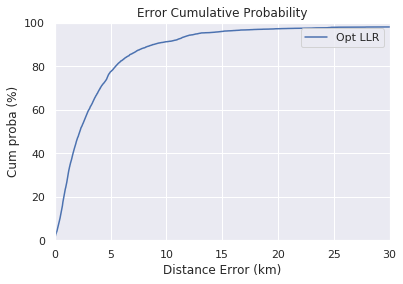

In [37]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0)
plt.xlabel('Distance Error (km)')
plt.ylabel('Cum proba (%)')
plt.axis([0, 30, 0, 100]) 
plt.title('Error Cumulative Probability')
plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [38]:
# Error criterion
np.percentile(err_vec, 80)

5461.439091895561

## 5. Prédictions

On peut maintenant effectuer les prédictions sur le jeu test :

In [39]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng
    
    features = df_feat.columns.values[:-1]

    reg = KNeighborsRegressor(p=1,
                              n_neighbors=8,
                              weights = 'distance',
                              algorithm = 'brute')
    
    reg.fit(df_feat[features], ground_truth_lat)
    y_pred_lat = reg.predict(df_test[features]) 
    
    reg.fit(df_feat[features], ground_truth_lng)
    y_pred_lng = reg.predict(df_test[features]) 
    
    return y_pred_lat, y_pred_lng

In [40]:
df_feat_test, id_list_test = feat_mat_const(df_mess_test, listOfBs)

In [43]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

In [44]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

In [45]:
test_res.to_csv('output/pred_pos_test_list.csv', index=False)

In [46]:
test_res.head()

,lat,lng,messid
0,39.714973,-105.055136,573be2503e952e191262c351
1,39.774187,-105.078610,573c05f83e952e1912758013
2,39.687522,-105.014131,573c0796f0fe6e735a66deb3
3,39.803398,-105.080390,573c08d2864fce1a9a0563bc
4,39.687032,-105.014922,573c08ff864fce1a9a0579b0


/home/antonin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/antonin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/antonin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


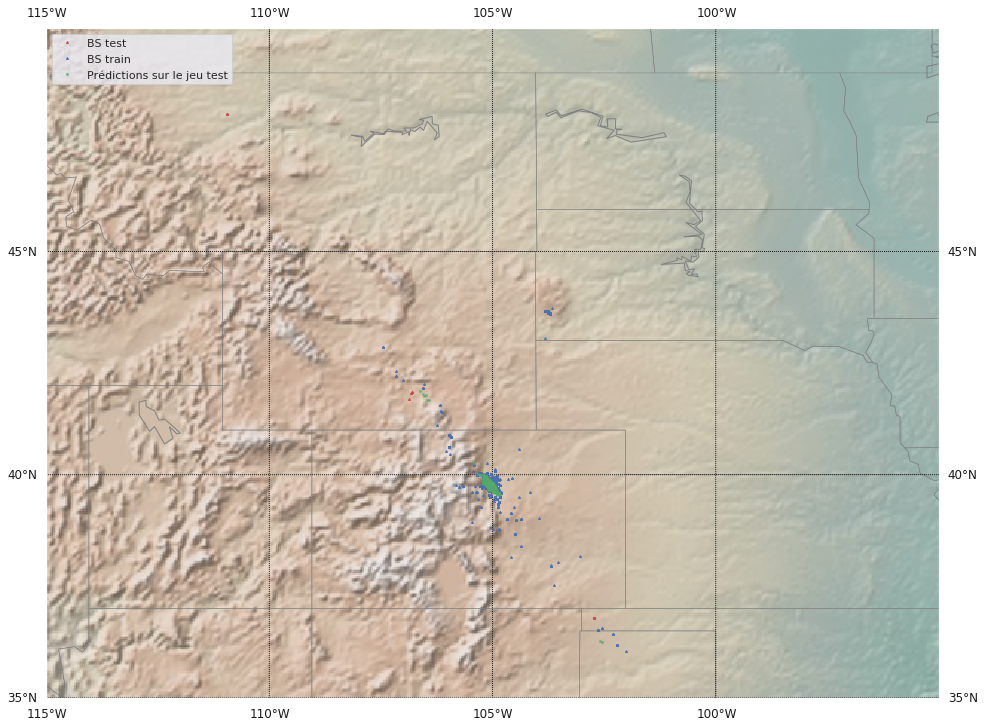

In [47]:
# Carte des prédictions obtenues sur le jeu test 

# Background
fig = plt.figure(figsize=(16, 16))
m = Basemap(projection='cyl', resolution='l',
            llcrnrlon=-115, llcrnrlat= 35, 
            urcrnrlon=-95, urcrnrlat=50)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawparallels(np.arange(35,50,5), labels=[1,1,1,1])
m.drawmeridians(np.arange(-115,-95,5), labels=[1,1,1,1])

# Base stations test
bs_lat_test, bs_lng_test = m(df_mess_test.bs_lat.values, df_mess_test.bs_lng.values)
plt.plot(bs_lng_test, bs_lat_test,'^r', markersize=2, label='BS test')

# Base stations train
bs_lat_train, bs_lng_train = m(df_mess_train.bs_lat.values, df_mess_train.bs_lng.values)
plt.plot(bs_lng_train, bs_lat_train,'^b', markersize=2, label='BS train')

# Positions des objets calculée
device_lat, device_lng = m(pos_train.lat.values, pos_train.lng.values)
plt.plot(y_pred_lng, y_pred_lat,'xg', markersize=2, label='Prédictions sur le jeu test')

plt.legend()
plt.show()